## Spark Initialization

In [1]:
# Call findspark
import findspark
findspark.init()

In [2]:
# Import required library
from pyspark.sql import SparkSession

# Create Spark Session
spark = SparkSession \
    .builder \
    .appName("Python Spark SQL basic example") \
    .getOrCreate()

In [3]:
# Print Spark object ID
print(spark)

## Loading Data using Spark

In [4]:
# Datasets can be downloaded from https://www.kaggle.com/new-york-state/nys-511-ny-events
# Remove null values using na.drop
df = spark.read.csv("D:/TC/6BigData/Dataset/nys-511-ny-events/511-ny-events-beginning-2010.csv", header=True, inferSchema=True).na.drop()

In [5]:
# Convert the type of Latitude and Longitude values into double
df = df.withColumn("Latitude", df["Latitude"].cast("double"))
df = df.withColumn("Longitude", df["Longitude"].cast("double"))

In [6]:
df.schema

StructType(List(StructField(Event Type,StringType,true),StructField(Organization Name,StringType,true),StructField(Facility Name,StringType,true),StructField(Direction,StringType,true),StructField(City,StringType,true),StructField(County,StringType,true),StructField(State,StringType,true),StructField(Create Time,TimestampType,true),StructField(Close Time,TimestampType,true),StructField(Event Description,StringType,true),StructField(Responding Organization Id,StringType,true),StructField(Latitude,DoubleType,true),StructField(Longitude,DoubleType,true)))

In [7]:
df.count()

1099933

In [8]:
df.show()

+--------------------+--------------------+--------------------+---------------+--------------------+-----------+-----+-------------------+-------------------+--------------------+--------------------------+---------+----------+
|          Event Type|   Organization Name|       Facility Name|      Direction|                City|     County|State|        Create Time|         Close Time|   Event Description|Responding Organization Id| Latitude| Longitude|
+--------------------+--------------------+--------------------+---------------+--------------------+-----------+-----+-------------------+-------------------+--------------------+--------------------------+---------+----------+
|        construction|MTA NYC Transit S...|              D Line|    Bronx bound|      from Manhattan|   New York|   NY|2016-06-30 22:58:00|2016-07-01 05:15:00|Due to Constructi...|      MTA NYC Transit S...|40.769205|-73.984887|
|        construction|Port Authority Ne...|George Washington...|      Westbound|    

In [9]:
# Register the DataFrame as a SQL temporary view
df.createOrReplaceTempView("ny_events")

## Clustering

In [10]:
# Menampilkan data kejadian berdasarkan lokasi terjadinya
query1 = spark.sql("SELECT `Event Type`, `Event Description`, Latitude, Longitude \
            FROM ny_events").na.drop()

In [11]:
query1.show()

+--------------------+--------------------+---------+----------+
|          Event Type|   Event Description| Latitude| Longitude|
+--------------------+--------------------+---------+----------+
|        construction|Due to Constructi...|40.769205|-73.984887|
|        construction|Construction, exp...|40.850318|-73.945276|
|              delays|Delays on I-278 e...|  40.6916|-73.999099|
|              delays|Delays on I-95 no...|40.851501|-73.952102|
|        construction|Construction on I...|40.737598|-73.850601|
|              delays|Delays on I-278 w...|  40.7406|-73.899002|
|        construction|Due to Constructi...|40.824053|-73.944835|
|        construction|Construction on U...|40.728237|-74.102223|
|            roadwork|Road Work on I-95...|41.171118|-73.192596|
|    disabled vehicle|Disabled vehicle ...|42.256999|-73.613998|
|accident with inj...|Accident with Inj...|39.882305|-75.103304|
|            incident|Due to Delays, ea...|40.852352|-73.409812|
|    disabled vehicle|Dis

In [12]:
# Assembling Vector
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["Latitude", "Longitude"],
    outputCol='features')

query1 = assembler.transform(query1)
query1.show()

+--------------------+--------------------+---------+----------+--------------------+
|          Event Type|   Event Description| Latitude| Longitude|            features|
+--------------------+--------------------+---------+----------+--------------------+
|        construction|Due to Constructi...|40.769205|-73.984887|[40.769205,-73.98...|
|        construction|Construction, exp...|40.850318|-73.945276|[40.850318,-73.94...|
|              delays|Delays on I-278 e...|  40.6916|-73.999099|[40.6916,-73.999099]|
|              delays|Delays on I-95 no...|40.851501|-73.952102|[40.851501,-73.95...|
|        construction|Construction on I...|40.737598|-73.850601|[40.737598,-73.85...|
|              delays|Delays on I-278 w...|  40.7406|-73.899002|[40.7406,-73.899002]|
|        construction|Due to Constructi...|40.824053|-73.944835|[40.824053,-73.94...|
|        construction|Construction on U...|40.728237|-74.102223|[40.728237,-74.10...|
|            roadwork|Road Work on I-95...|41.171118|-

In [13]:
# Train model
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

kmeans = KMeans().setK(4).setSeed(1)
model = kmeans.fit(query1)

In [14]:
# Make a prediction
predictions = model.transform(query1)
predictions.show(5)

+------------+--------------------+---------+----------+--------------------+----------+
|  Event Type|   Event Description| Latitude| Longitude|            features|prediction|
+------------+--------------------+---------+----------+--------------------+----------+
|construction|Due to Constructi...|40.769205|-73.984887|[40.769205,-73.98...|         0|
|construction|Construction, exp...|40.850318|-73.945276|[40.850318,-73.94...|         0|
|      delays|Delays on I-278 e...|  40.6916|-73.999099|[40.6916,-73.999099]|         0|
|      delays|Delays on I-95 no...|40.851501|-73.952102|[40.851501,-73.95...|         0|
|construction|Construction on I...|40.737598|-73.850601|[40.737598,-73.85...|         0|
+------------+--------------------+---------+----------+--------------------+----------+
only showing top 5 rows



In [15]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.9095030982


In [16]:
# Shows the result
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[ 40.78559201 -74.01568581]
[41.42034982 41.42034982]
[-3.67614880e-05 -3.00501313e-06]
[ 42.79100573 -76.81967214]


In [17]:
# Visualization using pixiedust
import pixiedust

Pixiedust database opened successfully


In [18]:
display(predictions)

![cluster](img/cluster-1.png)

In [19]:
# Menampilkan total kejadian yang ditangani dari setiap organisasi
query2 = spark.sql("SELECT `Organization Name`, COUNT(`Organization Name`) AS `Total Event`\
                    FROM ny_events \
                    GROUP BY `Organization Name`").na.drop()

In [20]:
query2.show()

+--------------------+-----------+
|   Organization Name|Total Event|
+--------------------+-----------+
|      NJ Transit Bus|       8075|
| Staten Island Ferry|         73|
|Palisades Interst...|         91|
|Bergen County Police|         23|
| MTA Long Island Bus|          7|
|MTA Bridges and T...|          1|
| Westchester Co. DPW|       1061|
|       NJ DOT - STMC|     171157|
|   NYSDOT - Region 9|        787|
|Delaware River Po...|        222|
|  MTA Command Center|        182|
|             Megabus|          1|
|         NYSDOTR2379|         51|
|Port Authority NY...|          2|
| Meadowlands Complex|          4|
|Madison Square Ga...|          1|
|New Jersey Turnpi...|      18374|
|        JFK AirTrain|        625|
|Dover Township Po...|          1|
|Port Authority NY/NJ|      24366|
+--------------------+-----------+
only showing top 20 rows



In [21]:
# Assembling Vector
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(
    inputCols=["Total Event"],
    outputCol='features')

query2 = assembler.transform(query2)
query2.show()

+--------------------+-----------+----------+
|   Organization Name|Total Event|  features|
+--------------------+-----------+----------+
|      NJ Transit Bus|       8075|  [8075.0]|
| Staten Island Ferry|         73|    [73.0]|
|Palisades Interst...|         91|    [91.0]|
|Bergen County Police|         23|    [23.0]|
| MTA Long Island Bus|          7|     [7.0]|
|MTA Bridges and T...|          1|     [1.0]|
| Westchester Co. DPW|       1061|  [1061.0]|
|       NJ DOT - STMC|     171157|[171157.0]|
|   NYSDOT - Region 9|        787|   [787.0]|
|Delaware River Po...|        222|   [222.0]|
|  MTA Command Center|        182|   [182.0]|
|             Megabus|          1|     [1.0]|
|         NYSDOTR2379|         51|    [51.0]|
|Port Authority NY...|          2|     [2.0]|
| Meadowlands Complex|          4|     [4.0]|
|Madison Square Ga...|          1|     [1.0]|
|New Jersey Turnpi...|      18374| [18374.0]|
|        JFK AirTrain|        625|   [625.0]|
|Dover Township Po...|          1|

In [22]:
# Train model
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

kmeans = KMeans().setK(7).setSeed(1)
model = kmeans.fit(query2)

In [23]:
# Make a prediction
predictions = model.transform(query2)
predictions.show(5)

+--------------------+-----------+--------+----------+
|   Organization Name|Total Event|features|prediction|
+--------------------+-----------+--------+----------+
|      NJ Transit Bus|       8075|[8075.0]|         4|
| Staten Island Ferry|         73|  [73.0]|         0|
|Palisades Interst...|         91|  [91.0]|         0|
|Bergen County Police|         23|  [23.0]|         0|
| MTA Long Island Bus|          7|   [7.0]|         0|
+--------------------+-----------+--------+----------+
only showing top 5 rows



In [24]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.953533191302


In [25]:
# Shows the result
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

Cluster Centers: 
[290.39285714]
[171157.]
[38093.6]
[115871.]
[9481.66666667]
[53591.]
[22503.28571429]



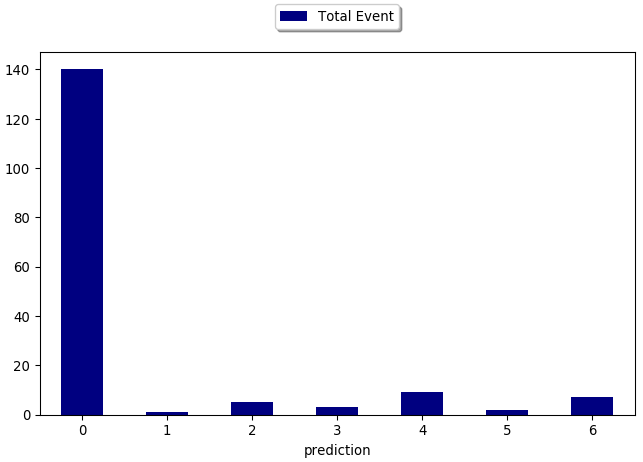

In [26]:
display(predictions)

![cluster](img/cluster-2.png)